In [142]:
from langgraph.graph import StateGraph,START,END
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_openai import AzureChatOpenAI,AzureOpenAIEmbeddings
from langchain_chroma.vectorstores import Chroma
from langchain_community.document_loaders import  DirectoryLoader,UnstructuredURLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain.prompts import PromptTemplate
from langchain_tavily import TavilySearch
import os
from typing import Annotated, Sequence, TypedDict,Literal
from langchain_core.messages import BaseMessage
import operator
from pydantic import BaseModel,Field
from IPython.display import display, Image

In [5]:
token_provider=get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")

chatmodel = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4.1",
    model= "gpt-4.1"
    )

embeddingmodel = AzureOpenAIEmbeddings( 
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "text-embedding-ada-002",
    model= "text-embedding-ada-002"
    )

In [ ]:
## Data Ingestion and Chunking
# Load data from 2 sources
document_loader= DirectoryLoader(path= "../data/",glob="*pdf", show_progress=True)
txtdata= document_loader.load()
weburl_loader = UnstructuredURLLoader(urls=["https://azure.microsoft.com/en-us/blog/focus-a-new-specification-for-cloud-cost-transparency/"],show_progress_bar=True)
webdata = weburl_loader.load()
all_docs = txtdata + webdata
len(all_docs)


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


In [ ]:
text_splitters = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=50,separators=["\n\n", "\n", " ", ""])
txtdatachunks=text_splitters.split_documents(all_docs)

In [105]:
#each chunk into ChromaDB
persist_directory = 'docs/chroma/'
chromadb = Chroma(collection_name="Focus-Data",embedding_function=embeddingmodel,persist_directory=persist_directory)
dataaddedtochroma = chromadb.add_documents(txtdatachunks)

In [ ]:
# Prompts
ragprompt = hub.pull("rlm/rag-prompt")
llmprompt = PromptTemplate(
    input_variables=["question"],
    template="""
    You are a smart assistant with access to the internet. Your job is to answer the following question using the most relevant and recent information found on the web.
    Question: {question}
    
    Instructions:
    1. Search the web to find accurate, up-to-date information.
    2. Summarize your findings clearly.
    3. Include relevant facts, sources, and dates if available.
    Only include information that is verified and recent.

    Answer:
    """
)
supervisorprompt= PromptTemplate(
    input_variables=["question"],
    template="""
    You are an intelligent assistant responsible for classifying user queries based on their content.

Classify the query into one of the following categories:

- "rag": Use this only when the query is related to **Azure Billing as it supports or integrates with the FOCUS platform**. Also use this if the question requires information from internal documentation specifically related to Azure Billing in the FOCUS context.
- "web": Use this for questions that require up-to-date, real-time, or public information available on the internet.
- "llm": Use this for general-purpose reasoning, creative writing, or queries not dependent on internal documentation or current events.

Respond with one word only: **rag**, **web**, or **llm**.

---

Examples:

Query: How does Azure Billing data feed into FOCUS reports?
Classification: rag

Query: What billing APIs does FOCUS rely on for Azure cost tracking?
Classification: rag

Query: Who won the Champions League this year?
Classification: web

Query: Write a tagline for a new health-tech product.
Classification: llm

Query: What are the differences between FOCUS billing and Azure native billing dashboards?
Classification: rag

Query: What's the current exchange rate between USD and EUR?
Classification: web

Query: How do I interpret a cost anomaly in FOCUS from Azure Billing data?
Classification: rag

---

Now classify the following:

Query: {query}
Classification:
    """
)

validateprompt = PromptTemplate(
    input_variables=["question","answer_to_validate"],
    template= """
    You are an expert reviewer. Your task is to validate whether the following answer correctly and completely addresses the given question.

Evaluate the response based on:
1. Accuracy - Is the information factually correct?
2. Completeness - Does the answer fully address the question?
3. Relevance - Is the response focused and appropriate to the question?

Respond with one word only: **yes** or **no**.
---
Question:
{question}
Answer:
{answer_to_validate}
Evaluation:
"""
)

rewriteprompt = PromptTemplate(
input_variables=["original_question","answer"],
template="""
You are a prompt improvement assistant.
Given a user's original question and an answer generated for it, your task is to rewrite the question so that it:
- More clearly reflects what the answer is about,
- Is unambiguous and easy to understand,
- Aligns better with the style and scope of the answer received,
- Preserves the user's original intent as much as possible.

Return only the rewritten question.
---
Original Question:
{original_question}

Answer:
{answer}

Rewritten Question:
"""
)

In [126]:
#chromadata=chromadb.similarity_search_with_score( query="What is availability zone?",k=5)
# Function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Set up the retriever from the Chroma vector store
retriever = chromadb.as_retriever()
retriever

VectorStoreRetriever(tags=['Chroma', 'AzureOpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000296F181BB10>, search_kwargs={})

In [238]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    decision: Literal["rag", "llm", "web"]
    isvalid: Literal["yes","no"]
    newquestion : str

class formatinstructionsclass(BaseModel):
    call:str =  Field(description="This will tell which method to call.")
    reason:str = Field(description="This will give the reason why we choose the above method.")

def Supervisor(state : AgentState) -> AgentState:
    if state["isvalid"] == "no":
        input= state["newquestion"]
    else :
        input = state["messages"][0]       
    supervisorprompt1=supervisorprompt.format(query = input)
    response=chatmodel.invoke(supervisorprompt1)
    state["decision"]=response.content
    return state


In [239]:
Supervisor({"messages":["Does GCP supports FOCUS?"],"isvalid":"yes"})

{'messages': ['Does GCP supports FOCUS?'], 'isvalid': 'yes', 'decision': 'llm'}

In [240]:
# Create the RAG chain
def rag_call(state: AgentState)-> AgentState :    
    rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | ragprompt
    | chatmodel
    | StrOutputParser()
    )
    print("RAG Called")
    # Example query
    response = rag_chain.invoke(state["messages"][0])
    state["messages"]= [response]
    return state

In [182]:
rag_call({"messages":["Does GCP supports FOCUS?"]})

Langchain RAG pipeline set up successfully.
Based on the provided context, FOCUS is designed to standardize cost data and FinOps practices across all cloud providers. The context repeatedly mentions that FOCUS applies to "any provider," though it specifically references adoption on the Microsoft cloud. There is no explicit confirmation in the context that GCP (Google Cloud Platform) currently supports FOCUS, so I cannot confirm that GCP supports FOCUS based on the information given.


{'messages': 'Based on the provided context, FOCUS is designed to standardize cost data and FinOps practices across all cloud providers. The context repeatedly mentions that FOCUS applies to "any provider," though it specifically references adoption on the Microsoft cloud. There is no explicit confirmation in the context that GCP (Google Cloud Platform) currently supports FOCUS, so I cannot confirm that GCP supports FOCUS based on the information given.'}

In [ ]:
ragprompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [241]:
# Create LLM Call
def llm_call(state: AgentState)-> AgentState : 
    print("LLM Called")   
    llmchain= (
    {"question": RunnablePassthrough()}
    | llmprompt
    | chatmodel
    | StrOutputParser()
    )
    llmoutput=llmchain.invoke(state["messages"][0])
    state["messages"]= [llmoutput]
    return state

In [276]:
def web_call(state: AgentState)-> AgentState : 
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_APIKEY")
    print("WEB Called")
    tavily_tool =TavilySearch(
     max_results=1,
    topic="general",
    )
    webresponse=tavily_tool.invoke(state["messages"][0])
    state["messages"]=[webresponse["results"][0]["content"]]
    return state

In [277]:
def validate_call(state:AgentState) -> AgentState:    
    print("Validate Called")   
    answer_to_validate= state['messages'][-1]
    question = state["messages"][0]
    llmvalidatechain= (
    {"question": RunnablePassthrough(),"answer_to_validate" : RunnablePassthrough()}
    | validateprompt
    | chatmodel
    | StrOutputParser()
    )
    isvalid=llmvalidatechain.invoke({"question": question, "answer_to_validate": answer_to_validate})
    state["isvalid"]= isvalid
    print(f"---> Validate Response : {isvalid}")   
    return state  

In [ ]:
validate_call({"messages":["Does GCP supports FOCUS?","GCP is good"],"isvalid":"yes"})

Validate Called


{'messages': ['Does GCP supports FOCUS?', 'GCP is good'], 'isvalid': 'no'}

In [278]:
def rewrite_call(state : AgentState)-> AgentState:
    print("Rewrite Question Called")
    answer_validated= state['messages'][-1]
    question = state["messages"][0]   
    rewritechain= (
    {"original_question": RunnablePassthrough(),"answer" : RunnablePassthrough()}
    | rewriteprompt
    | chatmodel
    | StrOutputParser()
    )
    newquestion=rewritechain.invoke({"original_question": question, "answer": answer_validated})
    state["newquestion"]= newquestion
    print(f"------> New Question: {newquestion}")
    return state    

In [273]:
rewrite_call({"messages":["What billing APIs does FOCUS rely on for Azure cost tracking?"],"isvalid":"yes"})

Rewrite Question Called


{'messages': ['What billing APIs does FOCUS rely on for Azure cost tracking?'],
 'isvalid': 'yes',
 'newquestion': 'Which specific Azure billing APIs does FOCUS use to track and manage cloud costs?'}

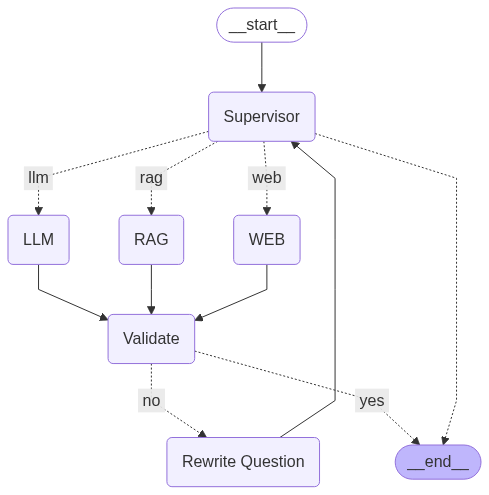

In [283]:
# Assuming AgentState is your state type
graph = StateGraph(AgentState)

# Add processing nodes
graph.add_node("Supervisor", Supervisor)
graph.add_node("RAG", rag_call)
graph.add_node("LLM", llm_call)
graph.add_node("WEB", web_call)
graph.add_node("Validate", validate_call)
graph.add_node("Rewrite Question", rewrite_call)


# Flow: Start → Supervisor
graph.add_edge(START, "Supervisor")

# Supervisor → branch based on decision
graph.add_conditional_edges(
    "Supervisor",
    lambda state: state["decision"],
    {
        "rag": "RAG",
        "llm": "LLM",
        "web": "WEB"
    }
)

# RAG / LLM / WEB → Validate
graph.add_edge("RAG", "Validate")
graph.add_edge("LLM", "Validate")
graph.add_edge("WEB", "Validate")

# Validate → yes → END, no → Rewrite
graph.add_conditional_edges(
    "Validate",
    lambda state: state["isvalid"],
    {
        "yes": END,
        "no": "Rewrite Question"
    }
)

# Rewrite Question → Supervisor (loopback)
graph.add_edge("Rewrite Question", "Supervisor")

compiledgraph= graph.compile()


display(Image(data=compiledgraph.get_graph().draw_mermaid_png()))

In [280]:
graphoutput=compiledgraph.invoke({"messages":["What billing APIs does FOCUS rely on for Azure cost tracking?"],"isvalid":"yes"})
graphoutput["messages"][-1]

RAG Called
Validate Called
---> Validate Response : no
Rewrite Question Called
------> New Question: How does the FinOps Open Cost and Usage Specification (FOCUS) enable standardized cost tracking in Azure?
LLM Called
Validate Called
---> Validate Response : yes


"Based on recent and reliable sources, FOCUS (the FinOps Open Cost and Usage Specification) relies on the following Azure billing APIs for Azure cost tracking:\n\n1. Azure Cost Management + Billing APIs:  \n   - **Consumption API**: Provides access to usage and cost data for Azure resources. Used to retrieve granular cost and usage details such as daily/monthly usage, cost by resource, tag, etc.\n   - **UsageDetails API**: Part of the Consumption API, specifically delivers detailed resource-level spend and usage records, which are important for constructing a FOCUS-compliant dataset.\n   - **Reservation APIs**: Supplies reserved instance utilization and cost breakdown.\n   - **Price Sheet API**: Gives pricing and rate card information to link raw usage data to actual costs.\n\n2. **Data Sources Used by FOCUS Implementations**:\n   - As noted in the official FOCUS specification and implementation guides (e.g., Microsoft's own FOCUS GitHub repo and FinOps Foundation documentation), Azure